# XGBoost (Extreme Gradient Boosting)

In [1]:
# Data Loading and Preprocessing 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('csv/pokemon_train.csv')
test_df = pd.read_csv('csv/pokemon_test.csv')

# Prepare features and targets
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X_train = train_df[features]
X_test = test_df[features]

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

In [2]:
# Model Implementation
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss, classification_report

# Primary Type Prediction
xgb_primary = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)

# Both Types Prediction
xgb_both = MultiOutputClassifier(xgb.XGBClassifier(eval_metric='mlogloss', random_state=42))

# Generation Prediction
xgb_generation = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)

In [3]:
from sklearn.preprocessing import LabelEncoder

# Primary Type Prediction
le_primary = LabelEncoder()
y_train_primary_encoded = le_primary.fit_transform(y_train_primary)
y_test_primary_encoded = le_primary.transform(y_test_primary)

xgb_primary.fit(X_train_scaled, y_train_primary_encoded)
y_pred_primary_encoded = xgb_primary.predict(X_test_scaled)
y_pred_primary = le_primary.inverse_transform(y_pred_primary_encoded)
accuracy_primary = accuracy_score(y_test_primary, y_pred_primary)
print("XGBoost - Primary Type Prediction:")
print(f"Accuracy: {accuracy_primary:.4f}")
print("Classification Report:")
print(classification_report(y_test_primary, y_pred_primary, zero_division=0))

# Both Types Prediction
xgb_both.fit(X_train_scaled, y_train_both_bin)
y_pred_both = xgb_both.predict(X_test_scaled)
hamming_loss_both = hamming_loss(y_test_both_bin, y_pred_both)
print("\nXGBoost - Both Types Prediction:")
print(f"Hamming Loss: {hamming_loss_both:.4f}")
print("Classification Report:")
print(classification_report(y_test_both_bin, y_pred_both, target_names=mlb.classes_, zero_division=0))

# Calculate exact match ratio
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
print(f"Exact Match Ratio: {exact_match_ratio:.4f}")

# Generation Prediction
le_generation = LabelEncoder()
y_train_generation_encoded = le_generation.fit_transform(y_train_generation)
y_test_generation_encoded = le_generation.transform(y_test_generation)

xgb_generation.fit(X_train_scaled, y_train_generation_encoded)
y_pred_generation_encoded = xgb_generation.predict(X_test_scaled)
y_pred_generation = le_generation.inverse_transform(y_pred_generation_encoded)
accuracy_generation = accuracy_score(y_test_generation, y_pred_generation)
print("\nXGBoost - Generation Prediction:")
print(f"Accuracy: {accuracy_generation:.4f}")
print("Classification Report:")
print(classification_report(y_test_generation, y_pred_generation, zero_division=0))

XGBoost - Primary Type Prediction:
Accuracy: 0.2000
Classification Report:
              precision    recall  f1-score   support

         Bug       0.31      0.29      0.30        17
        Dark       0.00      0.00      0.00         9
      Dragon       0.20      0.14      0.17         7
    Electric       0.12      0.08      0.10        12
       Fairy       0.33      0.17      0.22         6
    Fighting       0.29      0.50      0.36         8
        Fire       0.15      0.15      0.15        13
      Flying       0.00      0.00      0.00         2
       Ghost       0.00      0.00      0.00         7
       Grass       0.16      0.15      0.15        20
      Ground       0.00      0.00      0.00         8
         Ice       0.20      0.17      0.18         6
      Normal       0.36      0.33      0.35        24
      Poison       0.12      0.12      0.12         8
     Psychic       0.29      0.33      0.31        12
        Rock       0.18      0.17      0.17        12
      

In [4]:
# CV and Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, hamming_loss

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [5]:
# Primary Type Prediction
print("XGBoost - Primary Type Prediction:")
grid_search_primary = GridSearchCV(xgb_primary, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_primary.fit(X_train_scaled, y_train_primary_encoded)
print("Best parameters:", grid_search_primary.best_params_)
print(f"Best cross-validation score: {grid_search_primary.best_score_:.4f}")

# Evaluate on test set
y_pred_primary_tuned = grid_search_primary.predict(X_test_scaled)
accuracy_primary_tuned = accuracy_score(y_test_primary_encoded, y_pred_primary_tuned)
print(f"Tuned model test accuracy: {accuracy_primary_tuned:.4f}")

XGBoost - Primary Type Prediction:
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation score: 0.2305
Tuned model test accuracy: 0.2000


In [6]:
# Generation Prediction
print("\nXGBoost - Generation Prediction:")
grid_search_generation = GridSearchCV(xgb_generation, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_generation.fit(X_train_scaled, y_train_generation_encoded)
print("Best parameters:", grid_search_generation.best_params_)
print(f"Best cross-validation score: {grid_search_generation.best_score_:.4f}")

# Evaluate on test set
y_pred_generation_tuned = grid_search_generation.predict(X_test_scaled)
accuracy_generation_tuned = accuracy_score(y_test_generation_encoded, y_pred_generation_tuned)
print(f"Tuned model test accuracy: {accuracy_generation_tuned:.4f}")


XGBoost - Generation Prediction:
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.2024
Tuned model test accuracy: 0.2195


In [7]:
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3],
    'estimator__subsample': [0.8, 1.0],
    'estimator__colsample_bytree': [0.8, 1.0]
}

# Both Types Prediction
print("\nXGBoost - Both Types Prediction:")

# Custom scorer for multi-label classification
hamming_scorer = make_scorer(hamming_loss, greater_is_better=False)

grid_search_both = GridSearchCV(xgb_both, param_grid, cv=5, scoring=hamming_scorer, n_jobs=-1)
grid_search_both.fit(X_train_scaled, y_train_both_bin)
print("Best parameters:", grid_search_both.best_params_)
print(f"Best cross-validation Hamming Loss: {-grid_search_both.best_score_:.4f}")

# Evaluate on test set
y_pred_both_tuned = grid_search_both.predict(X_test_scaled)
hamming_loss_both_tuned = hamming_loss(y_test_both_bin, y_pred_both_tuned)
print(f"Tuned model test Hamming Loss: {hamming_loss_both_tuned:.4f}")

# Calculate exact match ratio
exact_matches_tuned = np.all(y_pred_both_tuned == y_test_both_bin, axis=1)
exact_match_ratio_tuned = np.mean(exact_matches_tuned)
print(f"Tuned model Exact Match Ratio: {exact_match_ratio_tuned:.4f}")


XGBoost - Both Types Prediction:
Best parameters: {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 4, 'estimator__n_estimators': 200, 'estimator__subsample': 0.8}
Best cross-validation Hamming Loss: 0.0847
Tuned model test Hamming Loss: 0.0810
Tuned model Exact Match Ratio: 0.0098


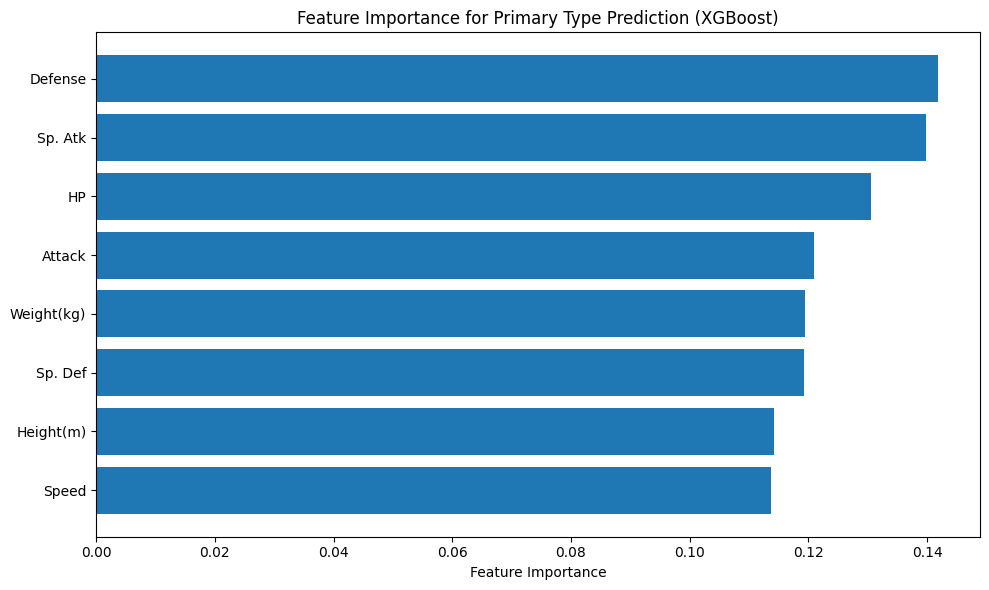

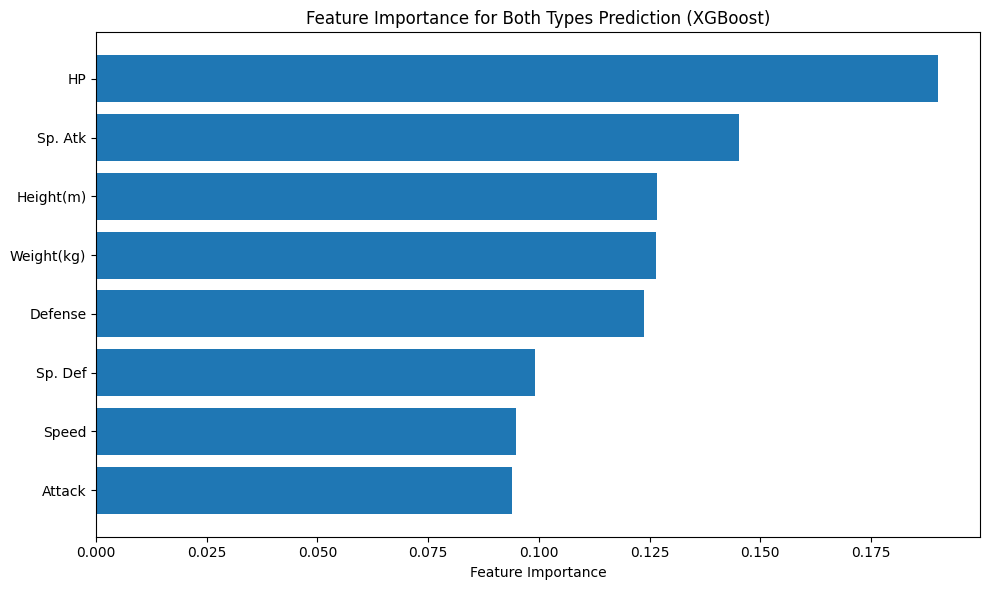

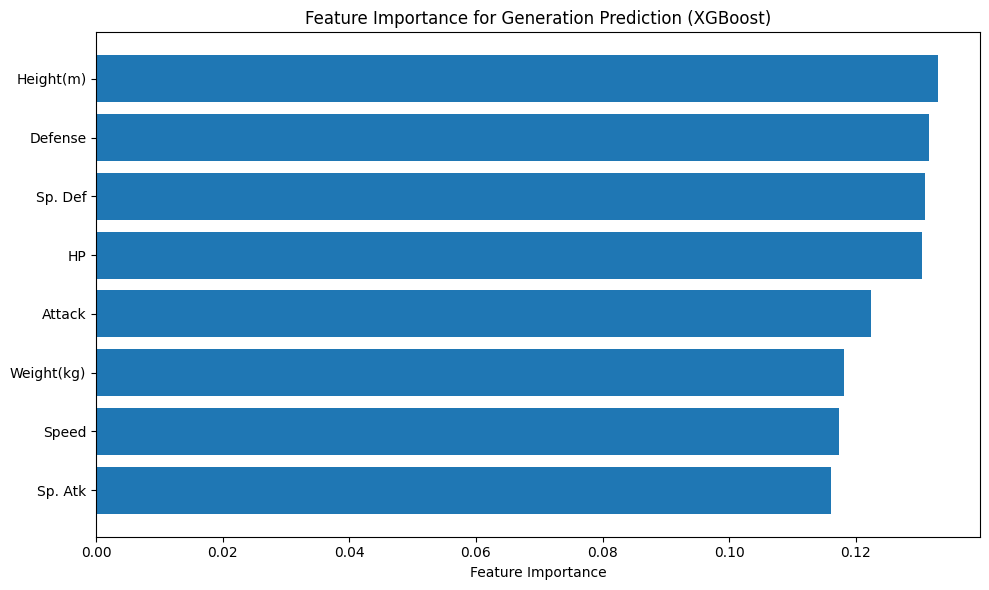

In [8]:
import matplotlib.pyplot as plt

def plot_feature_importance(importance, title):
    sorted_idx = importance.argsort()
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(10, 6))
    plt.barh(pos, importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(features)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Primary Type Feature Importance
plot_feature_importance(xgb_primary.feature_importances_, 'Feature Importance for Primary Type Prediction (XGBoost)')

# Both Types Feature Importance (using the first estimator)
plot_feature_importance(xgb_both.estimators_[0].feature_importances_, 'Feature Importance for Both Types Prediction (XGBoost)')

# Generation Feature Importance
plot_feature_importance(xgb_generation.feature_importances_, 'Feature Importance for Generation Prediction (XGBoost)')

## All features

In [1]:
# Data Loading and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('engineered_csv/train_combined_features.csv')
test_df = pd.read_csv('engineered_csv/test_combined_features.csv')

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Prepare features and targets
original_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
image_features = ['RGB_Mean', 'RGB_Std', 'RGB_Max', 'RGB_Min', 
                  'LBP_Mean', 'LBP_Std', 'LBP_Max', 'LBP_Min',
                  'CNN_Mean', 'CNN_Std', 'CNN_Max', 'CNN_Min']
engineered_features = [
    'Attack_Defense_Ratio', 'SpAtk_SpDef_Ratio', 'Speed_Avg_Ratio',
    'Physical_Total', 'Special_Total', 'Offensive_Total', 'Defensive_Total',
    'Stat_StdDev', 'Stat_Range', 'Highest_Stat_Percentage', 'Top_Two_Stat_Difference',
    'Physical_Bulk', 'Special_Bulk', 'Survivability_Index', 'Offensive_Potential',
    'BMI', 'Weight_Height_Ratio', 'Relative_Power', 'Type_Rarity'
]

all_features = original_features + engineered_features + image_features

# Check if all features are present in the dataframes
missing_features = [f for f in all_features if f not in train_df.columns or f not in test_df.columns]
if missing_features:
    print("Warning: The following features are missing:", missing_features)
    all_features = [f for f in all_features if f not in missing_features]

X_train = train_df[all_features]
X_test = test_df[all_features]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Extract names separately
train_names = train_df['Name']
test_names = test_df['Name']

print("\nNumber of train samples:", len(train_names))
print("Number of test samples:", len(test_names))

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

print("\nUnique primary types in train:", y_train_primary.nunique())
print("Unique primary types in test:", y_test_primary.nunique())
print("Unique generations in train:", y_train_generation.nunique())
print("Unique generations in test:", y_test_generation.nunique())

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

print("\nSample of y_train_both:", y_train_both[:5])
print("Sample of y_test_both:", y_test_both[:5])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nX_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

print("\ny_train_both_bin shape:", y_train_both_bin.shape)
print("y_test_both_bin shape:", y_test_both_bin.shape)
print("Classes:", mlb.classes_)

print("\nSample of y_train_both_bin:", y_train_both_bin[:5])
print("Sample of y_test_both_bin:", y_test_both_bin[:5])

# Handle categorical features
categorical_features = ['Size_Class', 'Speed_Tier']
X_train_cat = pd.get_dummies(train_df[categorical_features], prefix=categorical_features)
X_test_cat = pd.get_dummies(test_df[categorical_features], prefix=categorical_features)

# Ensure test set has all columns present in train set
for col in X_train_cat.columns:
    if col not in X_test_cat.columns:
        X_test_cat[col] = 0

# Align columns of test set with train set
X_test_cat = X_test_cat[X_train_cat.columns]

# Combine scaled numerical features with categorical features
X_train_final = np.hstack((X_train_scaled, X_train_cat))
X_test_final = np.hstack((X_test_scaled, X_test_cat))

print("\nX_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)

Train dataset shape: (820, 47)
Test dataset shape: (205, 47)
X_train shape: (820, 39)
X_test shape: (205, 39)

Number of train samples: 820
Number of test samples: 205

Unique primary types in train: 18
Unique primary types in test: 18
Unique generations in train: 9
Unique generations in test: 9

Sample of y_train_both: [['Dark', 'Psychic'], ['Psychic'], ['Psychic'], ['Normal', 'Flying'], ['Ghost']]
Sample of y_test_both: [['Dragon', 'Fighting'], ['Dark'], ['Normal', 'Psychic'], ['Grass'], ['Bug', 'Ground']]

X_train_scaled shape: (820, 39)
X_test_scaled shape: (205, 39)

y_train_both_bin shape: (820, 18)
y_test_both_bin shape: (205, 18)
Classes: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']

Sample of y_train_both_bin: [[0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
 [0 0 

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, jaccard_score, f1_score
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import numpy as np

# Initialize XGBoost classifiers
xgb_primary = XGBClassifier(random_state=42)
xgb_both = MultiOutputClassifier(XGBClassifier(random_state=42))
xgb_generation = XGBClassifier(random_state=42)

# Primary Type Prediction
le_primary = LabelEncoder()
y_train_primary_encoded = le_primary.fit_transform(y_train_primary)
y_test_primary_encoded = le_primary.transform(y_test_primary)

xgb_primary.fit(X_train_final, y_train_primary_encoded)
y_pred_primary_encoded = xgb_primary.predict(X_test_final)
y_pred_primary = le_primary.inverse_transform(y_pred_primary_encoded)
accuracy_primary = accuracy_score(y_test_primary, y_pred_primary)
print("XGBoost - Primary Type Prediction:")
print(f"Accuracy: {accuracy_primary:.4f}")
print("Classification Report:")
print(classification_report(y_test_primary, y_pred_primary, zero_division=0))

# Both Types Prediction
xgb_both.fit(X_train_final, y_train_both_bin)
y_pred_both = xgb_both.predict(X_test_final)
hamming_loss_both = hamming_loss(y_test_both_bin, y_pred_both)
print("\nXGBoost - Both Types Prediction:")
print(f"Hamming Loss: {hamming_loss_both:.4f}")
print("Classification Report:")
print(classification_report(y_test_both_bin, y_pred_both, target_names=mlb.classes_, zero_division=0))

# Calculate exact match ratio
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
print(f"Exact Match Ratio: {exact_match_ratio:.4f}")

# Calculate Jaccard Similarity Score
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
print(f"Jaccard Similarity Score: {jaccard_score_value:.4f}")

# Calculate F1 Score
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')
print(f"F1 Score: {f1_score_value:.4f}")

# Generation Prediction
le_generation = LabelEncoder()
y_train_generation_encoded = le_generation.fit_transform(y_train_generation)
y_test_generation_encoded = le_generation.transform(y_test_generation)

xgb_generation.fit(X_train_final, y_train_generation_encoded)
y_pred_generation_encoded = xgb_generation.predict(X_test_final)
y_pred_generation = le_generation.inverse_transform(y_pred_generation_encoded)
accuracy_generation = accuracy_score(y_test_generation, y_pred_generation)
print("\nXGBoost - Generation Prediction:")
print(f"Accuracy: {accuracy_generation:.4f}")
print("Classification Report:")
print(classification_report(y_test_generation, y_pred_generation, zero_division=0))

XGBoost - Primary Type Prediction:
Accuracy: 0.1854
Classification Report:
              precision    recall  f1-score   support

         Bug       0.44      0.24      0.31        17
        Dark       0.00      0.00      0.00         9
      Dragon       0.29      0.29      0.29         7
    Electric       0.08      0.08      0.08        12
       Fairy       0.25      0.33      0.29         6
    Fighting       0.17      0.12      0.14         8
        Fire       0.38      0.23      0.29        13
      Flying       0.00      0.00      0.00         2
       Ghost       0.00      0.00      0.00         7
       Grass       0.20      0.15      0.17        20
      Ground       0.00      0.00      0.00         8
         Ice       0.00      0.00      0.00         6
      Normal       0.15      0.38      0.21        24
      Poison       0.00      0.00      0.00         8
     Psychic       0.20      0.33      0.25        12
        Rock       0.50      0.08      0.14        12
      